# Data processing
The goal of this notebook is to convert data to JSON format that can be ingested by force directed graph visualization on web

In [1]:
import pandas as pd
import json

# Ingredient-Ingredient data

Example of output JSON format:
````
{
  "nodes": [
    {"id": "alginate", "group": 1},
    {"id": "sodium", "group": 1},
    {"id": "sodium alginate", "group": 1},
    {"id": "agar", "group": 1},
    {"id": "carrageenan", "group": 1}
  ],
  "links": [
    {"source": "alginate", "target": "sodium", "value": 1},
    {"source": "sodium alginate", "target": "agar", "value": 8},
    {"source": "carrageenan", "target": "agar", "value": 10}
  ]
}
````


In [2]:
ing_ing = pd.read_csv('ingredient-ingredient.csv')

# check length of docids for the first row
# print(len(json.loads(ing_ing.loc[0].docids)))

# convert docids from string to list
ing_ing["docids"] = ing_ing.apply(lambda row: json.loads(row["docids"]), axis=1)
# add column with docids count
ing_ing["docids_count"] = ing_ing.apply(lambda row: len(row["docids"]), axis=1)
print(ing_ing.describe())
ing_ing.head()

             times  docids_count
count  2761.000000   2761.000000
mean      5.087287      6.383919
std      23.147636     33.839899
min       1.000000      1.000000
25%       1.000000      1.000000
50%       1.000000      1.000000
75%       3.000000      3.000000
max     547.000000   1033.000000


first           second  times  \
0  alginate         alginate    547   
1  alginate           sodium    532   
2  alginate  sodium alginate    508   
3    sodium  sodium alginate    508   
4    sodium           sodium    200   

                                              docids  docids_count  
0  [3, 5, 6, 7, 10, 12, 13, 14, 15, 16, 17, 18, 1...          1033  
1  [3, 6, 10, 12, 14, 16, 19, 20, 21, 23, 24, 25,...           532  
2  [3, 6, 10, 12, 14, 16, 19, 20, 21, 23, 24, 25,...           508  
3  [3, 6, 10, 12, 14, 16, 19, 20, 21, 23, 24, 25,...           508  
4  [3, 6, 10, 11, 12, 14, 16, 19, 20, 21, 23, 24,...           564

### "times" to "docids" ratio

<AxesSubplot:xlabel='times'>

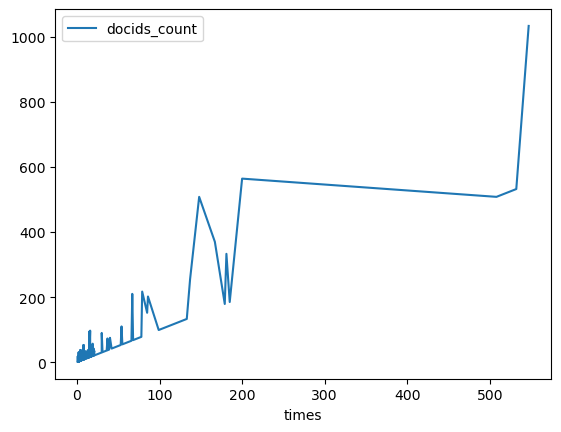

In [3]:
ing_ing.plot(x="times", y="docids_count")

### Plot distribution

<AxesSubplot:ylabel='Density'>

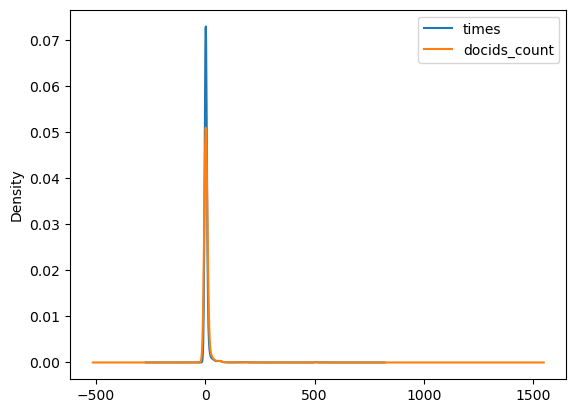

In [4]:
ing_ing.plot(kind='kde')

### Compare ingredient names

In [5]:
len(ing_ing["first"].unique())

208

In [6]:
len(ing_ing["second"].unique())

224

### Filter data

Filter rows whose "times" and "docids_count" value are below a threshold

In [7]:
def filter_low_values(df):
    times_thresh = 5
    docids_thresh = 20
    filtered_times = df[df['times'] > times_thresh]
    print("Dropped after times <",times_thresh ,"=", len(df)-len(filtered_times))
    filtered_docids = filtered_times[filtered_times['docids_count'] > docids_thresh]
    print("Dropped after docids_count <",docids_thresh,"=", len(filtered_times)-len(filtered_docids))
    print("Final rows",len(filtered_docids))
    filtered_docids.plot(kind='kde')
    return filtered_docids

Dropped after times < 5 = 2363
Dropped after docids_count < 20 = 282
Final rows 116


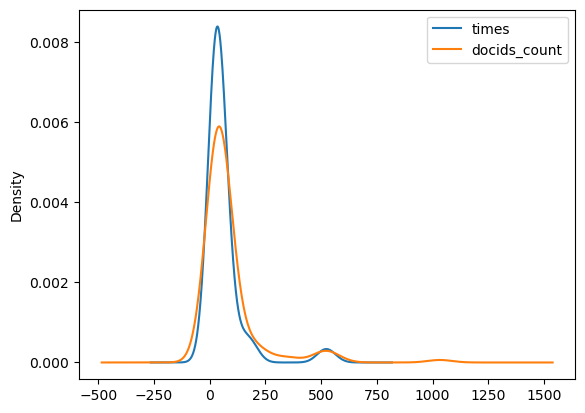

In [8]:
filtered_ing_ing = filter_low_values(ing_ing)

Filter rows whose ingredient names are equal. Since we can't visualize rows like: "alginate" - "alginate"

In [9]:
def filter_repeated_links(df):
    somelist = []
    for index, row in df.iterrows():
        if row["first"] != row["second"]:
            somelist.append(row)
    return pd.DataFrame(somelist)

In [10]:
filtered_no_repeat_ing_ing = filter_repeated_links(filtered_ing_ing)
print("Dropped",len(filtered_ing_ing)- len(filtered_no_repeat_ing_ing), "rows")
print("Final rows:",len(filtered_no_repeat_ing_ing) )
filtered_no_repeat_ing_ing.head()

Dropped 36 rows
Final rows: 80


first           second  times  \
1  alginate           sodium    532   
2  alginate  sodium alginate    508   
3    sodium  sodium alginate    508   
5  alginate          calcium    185   
7  alginate         chitosan    179   

                                              docids  docids_count  
1  [3, 6, 10, 12, 14, 16, 19, 20, 21, 23, 24, 25,...           532  
2  [3, 6, 10, 12, 14, 16, 19, 20, 21, 23, 24, 25,...           508  
3  [3, 6, 10, 12, 14, 16, 19, 20, 21, 23, 24, 25,...           508  
5  [5, 7, 13, 29, 33, 62, 79, 97, 98, 116, 118, 1...           185  
7  [5, 10, 17, 23, 30, 35, 52, 101, 127, 138, 146...           179

By the end of the filter process times and docids_count are the same...

<AxesSubplot:xlabel='times'>

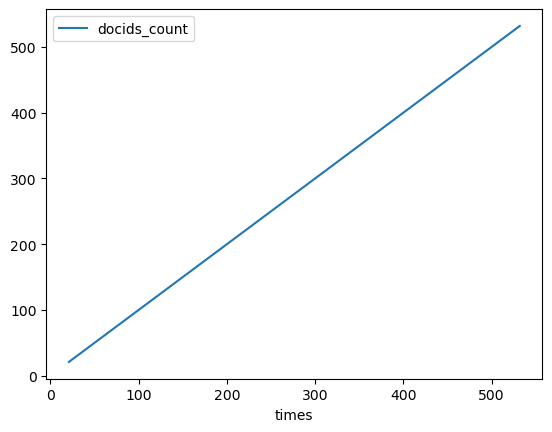

In [17]:
filtered_no_repeat_ing_ing.plot(x="times", y="docids_count")

### Data export
Export data for d3 force graph visualization

In [11]:
def create_nodes(df):
    # list of all unique nodes in both columns in json format
    ing_list =[]
    unique_union = list(set(df["first"].unique()).union(set(df["second"].unique())))
    for ingredient in unique_union:
        ing_dict = {}
        ing_dict["id"] = ingredient
        ing_list.append(ing_dict)
    return ing_list

In [12]:
nodes_list = create_nodes(filtered_no_repeat_ing_ing)

In [13]:
def create_links(df):
    # list all rows
    link_list = []
    for index, row in df.iterrows():
        link_dict = {}
        link_dict["source"] = row["first"]
        link_dict["target"] = row["second"]
        link_dict["force"] = row["times"]
        link_dict["doc_count"] = row["docids_count"]
        link_list.append(link_dict)
    return link_list

In [14]:
links_list = create_links(filtered_no_repeat_ing_ing)

In [15]:
def join_lists(links_list,nodes_list):
    out_dict ={}
    out_dict["nodes"] = nodes_list
    out_dict["links"] = links_list
    return out_dict

In [16]:
links_and_nodes = join_lists(links_list,nodes_list)
links_and_nodes

{'nodes': [{'id': 'soy'},
  {'id': 'xanthan'},
  {'id': 'agar'},
  {'id': 'sodium'},
  {'id': 'chitosan'},
  {'id': 'alcohol'},
  {'id': 'cellulose'},
  {'id': 'κ carrageenan'},
  {'id': 'collagen'},
  {'id': 'sodium alginate'},
  {'id': 'zinc'},
  {'id': 'carbon'},
  {'id': 'carrageenan'},
  {'id': 'graphene'},
  {'id': 'methyl'},
  {'id': 'pectin'},
  {'id': 'graphene oxide'},
  {'id': 'propylene'},
  {'id': 'xanthan gum'},
  {'id': 'chloride'},
  {'id': 'starch'},
  {'id': 'poly vinyl alcohol'},
  {'id': 'silver'},
  {'id': 'calcium chloride'},
  {'id': 'glycerol'},
  {'id': 'alginate'},
  {'id': 'whey protein'},
  {'id': 'polyethylene glycol'},
  {'id': 'soy protein'},
  {'id': 'gelatin'},
  {'id': 'gum'},
  {'id': 'calcium'}],
 'links': [{'source': 'alginate',
   'target': 'sodium',
   'force': 532,
   'doc_count': 532},
  {'source': 'alginate',
   'target': 'sodium alginate',
   'force': 508,
   'doc_count': 508},
  {'source': 'sodium',
   'target': 'sodium alginate',
   'force':

Save json file

In [20]:
with open('ing_ing.json', 'w') as fp:
    json.dump(links_and_nodes, fp)